### **Latent Dirichlet Allocation**

In this workbook, we will employ LDA on text data to discover the topics discussed:
- xxx
- xxx
- xxx

In [17]:
# nltk.download('punkt')
# nltk.download('stopwords')

In [23]:
# pip install wordcloud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import textblob
import gensim
import tqdm
from PIL import Image

from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, ImageColorGenerator

In [2]:
df_processed = pd.read_excel("amazon_review_processed_full.xlsx")
df_processed.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'amazon_review_processed_full.xlsx'

In [3]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10209 entries, 0 to 10208
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Review Model              10209 non-null  object        
 1   Retailer                  10209 non-null  object        
 2   Review date               10209 non-null  datetime64[ns]
 3   Review name               10152 non-null  object        
 4   Review rating             10209 non-null  int64         
 5   Review title              10018 non-null  object        
 6   Review Content            10200 non-null  object        
 7   Verified Purchase or not  10209 non-null  bool          
 8   People_find_helpful       10209 non-null  float64       
 9   vine or not               10209 non-null  bool          
 10  URL                       10209 non-null  object        
 11  list price                10209 non-null  float64       
 12  rating count      

#### <font color=#FFB703> **Topic Modelling on Full Corpus** </font>

<font color=#61BEB0>**Tokenisation:**</font>

In [3]:
# Tokenisation (Review Content)
df_processed['Tokenized Full'] = df_processed['Full review'].apply(lambda x: word_tokenize(str(x)) if isinstance(x, str) else [])
df_processed[['Full review', 'Tokenized Full']].head(5)

Full review  \
0                  work great easi instal work great   
1  spunki mid size slower speed im use old model ...   
2                                                  i   
3  shag know he talk yup slam upgrad paid littl f...   
4  user friendli would think someth simpl reconne...   

                                      Tokenized Full  
0           [work, great, easi, instal, work, great]  
1  [spunki, mid, size, slower, speed, im, use, ol...  
2                                                [i]  
3  [shag, know, he, talk, yup, slam, upgrad, paid...  
4  [user, friendli, would, think, someth, simpl, ...

<font color=#61BEB0>**Select Number of Topics:**</font>

Code adapted from: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Coherence%20Measures,-Let's%20take%20quick&text=C_v%20measure%20is%20based%20on,NPMI)%20and%20the%20cosine%20similarity

In [5]:
#create dictionary and corpus
dictionary = corpora.Dictionary(df_processed['Tokenized Full'])
corpus = [dictionary.doc2bow(text) for text in df_processed['Tokenized Full']]

In [32]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_processed['Tokenized Full'], dictionary=dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [10]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_umass.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 390/390 [2:35:28<00:00, 23.92s/it]


In [11]:
lda_results = pd.read_csv("lda_tuning_results_umass.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -1.657403
1       2  0.01                0.31  -1.668079
2       2  0.01                0.61  -1.650044
3       2  0.01  0.9099999999999999  -1.653824
4       2  0.01           symmetric  -1.644616

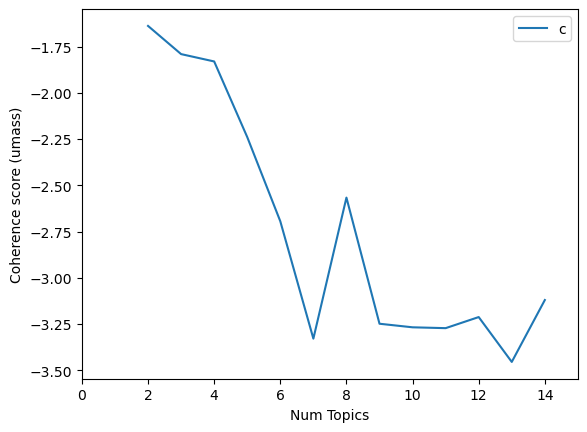

In [13]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 15))
plt.xticks(np.arange(0, 15, step=2))
plt.show()

Umass takes the range of -14 to 14. Higher values indicate that better topics as common words of a topic co-occur frequently within documents. We will take the greatest number of topics before a sharp drop in the coherence score, which is 3 or 4 topics.

References:
https://www.baeldung.com/cs/topic-modeling-coherence-score#:~:text=We%20can%20use%20the%20coherence,words%20are%20to%20each%20other.
https://datascience.oneoffcoder.com/topic-modeling-gensim.html

In [14]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
48       3  0.9099999999999999  0.9099999999999999  -1.669773
47       3  0.9099999999999999                0.61  -1.672240
42       3                0.61                0.61  -1.675591
43       3                0.61  0.9099999999999999  -1.677154
53       3           symmetric  0.9099999999999999  -1.689512
45       3  0.9099999999999999                0.01  -1.701621
41       3                0.61                0.31  -1.707265
44       3                0.61           symmetric  -1.711123
40       3                0.61                0.01  -1.719428
75       4  0.9099999999999999                0.01  -1.720118
38       3                0.31  0.9099999999999999  -1.728127
67       4                0.31                0.61  -1.728833
52       3           symmetric                0.61  -1.730275
37       3                0.31                0.61  -1.731834
70       4                0.61                0.01  -1.735957
36       3                0.31                0.31  -1.736161
46       3  0.9099999999999999                0.31  -1.757449
81       4           symmetric                0.31  -1.759345
39       3                0.31           symmetric  -1.759874
65       4                0.31                0.01  -1.760232
73       4                0.61  0.9099999999999999  -1.760392
64       4                0.01           symmetric  -1.760426
49       3  0.9099999999999999           symmetric  -1.760621
82       4           symmetric                0.61  -1.761054
35       3                0.31                0.01  -1.761094
50       3           symmetric                0.01  -1.761106
66       4                0.31                0.31  -1.764346
72       4                0.61                0.61  -1.769848
51       3           symmetric                0.31  -1.770043
69       4                0.31           symmetric  -1.786685
54       3           symmetric           symmetric  -1.790637
78       4  0.9099999999999999  0.9099999999999999  -1.791517
61       4                0.01                0.31  -1.792083
80       4           symmetric                0.01  -1.797615
60       4                0.01                0.01  -1.802743
30       3                0.01                0.01  -1.804768
77       4  0.9099999999999999                0.61  -1.805549
74       4                0.61           symmetric  -1.808473
76       4  0.9099999999999999                0.31  -1.823390
55       3          asymmetric                0.01  -1.830391
84       4           symmetric           symmetric  -1.830405
79       4  0.9099999999999999           symmetric  -1.833558
71       4                0.61                0.31  -1.851226
85       4          asymmetric                0.01  -1.910525
68       4                0.31  0.9099999999999999  -2.076470
83       4           symmetric  0.9099999999999999  -2.148050
34       3                0.01           symmetric  -2.218079
31       3                0.01                0.31  -2.224495
89       4          asymmetric           symmetric  -2.590787
86       4          asymmetric                0.31  -2.832489
62       4                0.01                0.61  -2.874925
87       4          asymmetric                0.61  -3.100060
59       3          asymmetric           symmetric  -3.263328
56       3          asymmetric                0.31  -3.267525
32       3                0.01                0.61  -3.432906
57       3          asymmetric                0.61  -3.969889
63       4                0.01  0.9099999999999999  -4.141179
88       4          asymmetric  0.9099999999999999  -4.400752
58       3          asymmetric  0.9099999999999999  -4.657099
33       3                0.01  0.9099999999999999  -5.117781

<font color=#61BEB0>**Execute Topic Modelling:**</font>

In [16]:
k=3
a= 0.9099999999999999
b= 0.9099999999999999

lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [17]:
topics = lda_model.print_topics(num_words=20)
for topic in topics:
    print(topic)

(0, '0.022*"great" + 0.022*"easi" + 0.022*"good" + 0.022*"qualiti" + 0.015*"print" + 0.013*"color" + 0.011*"like" + 0.010*"photo" + 0.009*"copi" + 0.009*"price" + 0.009*"need" + 0.008*"use" + 0.008*"scan" + 0.008*"well" + 0.008*"home" + 0.008*"epson" + 0.007*"love" + 0.007*"tray" + 0.007*"work" + 0.006*"printer"')
(1, '0.015*"cartridg" + 0.015*"time" + 0.015*"work" + 0.014*"buy" + 0.011*"month" + 0.010*"page" + 0.009*"tri" + 0.009*"bought" + 0.008*"would" + 0.008*"new" + 0.008*"dont" + 0.008*"support" + 0.008*"epson" + 0.007*"back" + 0.007*"even" + 0.007*"purchas" + 0.007*"return" + 0.006*"year" + 0.006*"2" + 0.006*"never"')
(2, '0.027*"connect" + 0.023*"work" + 0.016*"wifi" + 0.015*"app" + 0.014*"scan" + 0.014*"instal" + 0.013*"setup" + 0.013*"comput" + 0.011*"phone" + 0.009*"can" + 0.009*"softwar" + 0.008*"wireless" + 0.007*"smart" + 0.007*"tri" + 0.006*"time" + 0.006*"network" + 0.006*"need" + 0.006*"devic" + 0.006*"instruct" + 0.006*"find"')


In [12]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [20]:
visual= pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.096146  0.148172       1        1  41.263523
0     -0.205300 -0.006130       2        1  29.641716
2      0.109155 -0.142042       3        1  29.094761, topic_info=        Term         Freq        Total Category  logprob  loglift
237  connect  3300.000000  3300.000000  Default  30.0000  30.0000
163  qualiti  2645.000000  2645.000000  Default  29.0000  29.0000
1      great  2805.000000  2805.000000  Default  28.0000  28.0000
0       easi  2933.000000  2933.000000  Default  27.0000  27.0000
14      good  2940.000000  2940.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
83       tri   801.140365  2395.063025   Topic3  -5.0107   0.1395
176     need   757.412016  2462.072829   Topic3  -5.0668   0.0558
150     time   774.857679  3542.692659   Topic3  -5.0441  -0.2854
182     want   628.621952  1779.369239   Topic3  -5.2532   0.1941
44       use   647.938674  2451.508704   Topic3  -5.2229  -0.0961

[206 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
270       1  0.709873      2
270       2  0.101791      2
270       3  0.188279      2
271       1  0.909875      3
271       2  0.062255      3
...     ...       ...    ...
133       2  0.167038  would
133       3  0.199023  would
87        1  0.709883   year
87        2  0.280789   year
87        3  0.009228   year

[498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

From the top key words, we can roughly guess that these are the 3 topics:
- 0: print/scan/photocopy quality
- 1: catridge lifespan
- 2: printer setup and installation

However, the results may be improved by using a bigram model and removing more words that muddy the topic modeling. For example common words like "printer" or "epson" and opinion words like "great" and "like".

<font color=#61BEB0>**Refine Inputs:**</font>

In [4]:
#remove more words
newstop = ['print', "printer", "epson", "canon", "great", "good", "can", "like", "love", "want", "need", "work", 
           "much", "awesom", "nice", "would", "use", "well", "also"]
df_processed['Full review'] = df_processed['Full review'].apply(lambda x: " ".join(x for x in x.split() if x not in newstop))

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

textlist = df_processed['Full review'].values.tolist()
textlist_words = list(sent_to_words(textlist))

In [6]:
#identify phrases
bigram = Phrases(textlist_words, min_count=5, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [7]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

textlist_bigrams = make_bigrams(textlist_words)

In [8]:
dictionary = corpora.Dictionary(textlist_bigrams)

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in textlist_bigrams]

In [9]:
#try 3 topics
k=3
a= 0.9099999999999999
b= 0.9099999999999999

lda_model3 = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [10]:
topics = lda_model3.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.013*"easi" + 0.012*"qualiti" + 0.009*"color" + 0.008*"photo" + 0.006*"price" + 0.006*"copi" + 0.006*"far" + 0.005*"tray" + 0.005*"realli" + 0.005*"look"')
(1, '0.011*"app" + 0.011*"scan" + 0.010*"comput" + 0.010*"wifi" + 0.009*"connect" + 0.008*"setup" + 0.007*"instal" + 0.007*"phone" + 0.007*"softwar" + 0.006*"wireless"')
(2, '0.011*"cartridg" + 0.010*"time" + 0.009*"buy" + 0.008*"bought" + 0.007*"tri" + 0.006*"page" + 0.006*"purchas" + 0.006*"month" + 0.005*"return" + 0.005*"even"')


The 3 topics still look quite similar to the first model but the top keywords are more focused.

In [13]:
visual= pyLDAvis.gensim_models.prepare(lda_model3, corpus, dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.097982  0.128910       1        1  39.180486
1     -0.083811 -0.135788       2        1  31.407664
0      0.181792  0.006878       3        1  29.411849, topic_info=         Term         Freq        Total Category  logprob  loglift
453   qualiti  1075.000000  1075.000000  Default  30.0000  30.0000
42       easi  1190.000000  1190.000000  Default  29.0000  29.0000
144       app  1032.000000  1032.000000  Default  28.0000  28.0000
76     comput   979.000000   979.000000  Default  27.0000  27.0000
279      wifi   908.000000   908.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
361    machin   281.734056   575.603128   Topic3  -5.7504   0.5093
40   cartridg   346.929911  1638.873787   Topic3  -5.5422  -0.3289
643   scanner   287.555216   687.321865   Topic3  -5.7299   0.3524
484  document   273.708853   526.447026   Topic3  -5.7793   0.5697
772      make   271.159566   707.061320   Topic3  -5.7886   0.2654

[209 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
523       1  0.314707         abl
523       2  0.647926         abl
523       3  0.034967         abl
830       1  0.978795      amazon
830       2  0.015226      amazon
...     ...       ...         ...
789       2  0.014569  worst_ever
789       3  0.007285  worst_ever
71        1  0.671028        year
71        2  0.071452        year
71        3  0.257849        year

[516 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [42]:
fname = "lda_overall3"
print(fname)
lda_model3.save(fname)

lda_overall3


In [44]:
topic_keywords = []
for topic_id in range(lda_model3.num_topics):
    top_words = [word for word, prob in lda_model3.show_topic(topic_id, topn=10)]
    topic_keywords.append(top_words)

# Create a Pandas DataFrame from the list of lists
df_topic3 = pd.DataFrame(topic_keywords, columns=['Keyword 1', 'Keyword 2', 'Keyword 3', 'Keyword 4', 'Keyword 5', 'Keyword 6', 'Keyword 7', 'Keyword 8', 'Keyword 9', 'Keyword 10'])
df_topic3.index.name = 'Topic'
df_topic3.index += 1

# Print the DataFrame
df_topic3

Keyword 1 Keyword 2 Keyword 3 Keyword 4 Keyword 5 Keyword 6 Keyword 7  \
Topic                                                                         
1          easi   qualiti     color     photo     price      copi       far   
2           app      scan    comput      wifi   connect     setup    instal   
3      cartridg      time       buy    bought       tri      page   purchas   

      Keyword 8 Keyword 9 Keyword 10  
Topic                                 
1          tray    realli       look  
2         phone   softwar   wireless  
3         month    return       even

In [23]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

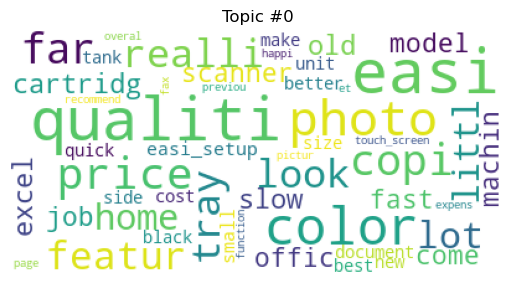

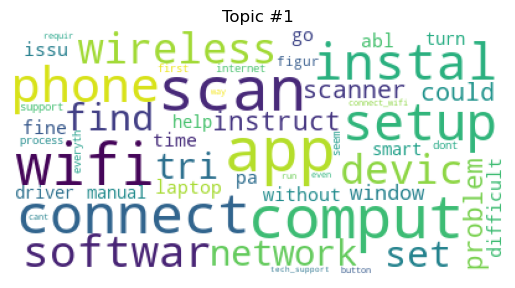

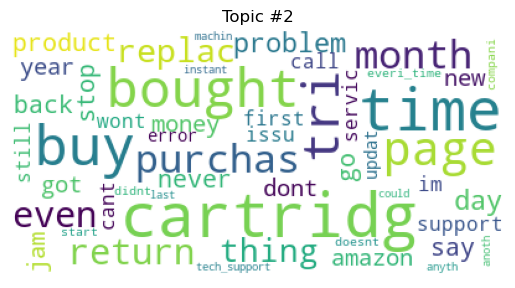

In [25]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [26]:
#try 4 topics
k= 4
a= 0.9099999999999999
b= 0.01

lda_model4 = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [27]:
topics = lda_model4.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.030*"easi" + 0.027*"qualiti" + 0.023*"color" + 0.018*"photo" + 0.017*"look" + 0.017*"realli" + 0.017*"scanner" + 0.016*"machin" + 0.014*"copi" + 0.014*"featur" + 0.013*"home" + 0.012*"lot" + 0.012*"littl" + 0.012*"black" + 0.012*"page"')
(1, '0.031*"scan" + 0.030*"time" + 0.027*"app" + 0.025*"comput" + 0.023*"wifi" + 0.022*"connect" + 0.018*"phone" + 0.017*"doesnt" + 0.015*"set" + 0.015*"thing" + 0.015*"wireless" + 0.014*"devic" + 0.013*"turn" + 0.013*"go" + 0.011*"dont"')
(2, '0.034*"cartridg" + 0.026*"buy" + 0.025*"bought" + 0.019*"purchas" + 0.017*"product" + 0.016*"month" + 0.015*"replac" + 0.012*"never" + 0.012*"time" + 0.012*"year" + 0.012*"say" + 0.012*"stop" + 0.012*"even" + 0.011*"money" + 0.011*"page"')
(3, '0.022*"problem" + 0.021*"tri" + 0.018*"issu" + 0.017*"day" + 0.017*"setup" + 0.017*"could" + 0.017*"first" + 0.016*"new" + 0.016*"instal" + 0.015*"support" + 0.014*"softwar" + 0.014*"got" + 0.013*"help" + 0.013*"start" + 0.013*"still"')


The 4 topics model appear to be slightly less distinctive than the 3 topics model with possible overlap between topics 1 and 3. These are the possible topic titles:
- 0: print/scan/photocopy quality
- 1: connecting with other devices
- 2: catridge lifespan
- 3: installation and customer support

In [28]:
visual= pyLDAvis.gensim_models.prepare(lda_model4, corpus, dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.278879 -0.219808       1        1  26.802059
2      0.108840 -0.111474       2        1  25.630089
1      0.297074 -0.016700       3        1  23.930268
0     -0.127035  0.347981       4        1  23.637584, topic_info=         Term         Freq        Total Category  logprob  loglift
409      scan  2217.000000  2217.000000  Default  30.0000  30.0000
40   cartridg  2848.000000  2848.000000  Default  29.0000  29.0000
42       easi  2157.000000  2157.000000  Default  28.0000  28.0000
453   qualiti  1941.000000  1941.000000  Default  27.0000  27.0000
144       app  1923.000000  1923.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
50        job   728.126196   956.006871   Topic4  -4.5823   1.1700
874     sheet   517.547180   565.806377   Topic4  -4.9237   1.3532
89       page   837.962695  1823.580783   Topic4  -4.4418   0.6647
209      cost   561.222169   784.344366   Topic4  -4.8427   1.1076
772      make   629.350689  1317.754486   Topic4  -4.7281   0.7033

[199 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
523       1  0.208763      abl
523       2  0.049444      abl
523       3  0.741657      abl
604       1  1.000430   actual
331       3  0.998872      add
...     ...       ...      ...
156       3  0.515489  without
430       2  0.695732     wont
430       3  0.303734     wont
71        2  0.827075     year
71        4  0.173088     year

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [43]:
fname = "lda_overall4"
print(fname)
lda_model4.save(fname)

lda_overall4


In [29]:
topic_keywords = []
for topic_id in range(lda_model4.num_topics):
    top_words = [word for word, prob in lda_model4.show_topic(topic_id, topn=10)]
    topic_keywords.append(top_words)

# Create a Pandas DataFrame from the list of lists
df_topic4 = pd.DataFrame(topic_keywords, columns=['Keyword 1', 'Keyword 2', 'Keyword 3', 'Keyword 4', 'Keyword 5', 'Keyword 6', 'Keyword 7', 'Keyword 8', 'Keyword 9', 'Keyword 10'])
df_topic4.index.name = 'Topic'
df_topic4.index += 1

# Print the DataFrame
df_topic4

Keyword 1 Keyword 2 Keyword 3 Keyword 4 Keyword 5 Keyword 6 Keyword 7  \
Topic                                                                         
1          easi   qualiti     color     photo      look    realli   scanner   
2          scan      time       app    comput      wifi   connect     phone   
3      cartridg       buy    bought   purchas   product     month    replac   
4       problem       tri      issu       day     setup     could     first   

      Keyword 8 Keyword 9 Keyword 10  
Topic                                 
1        machin      copi     featur  
2        doesnt       set      thing  
3         never      time       year  
4           new    instal    support

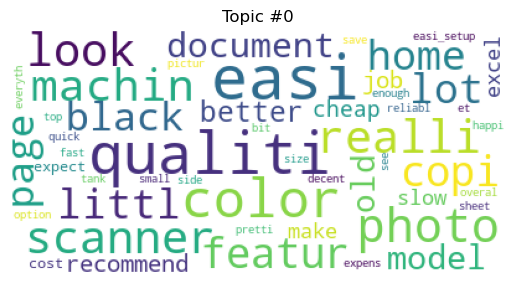

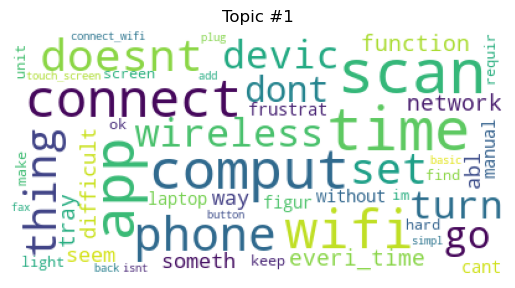

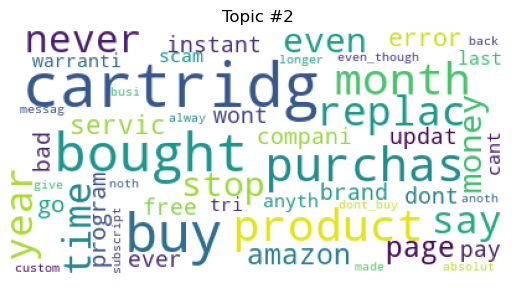

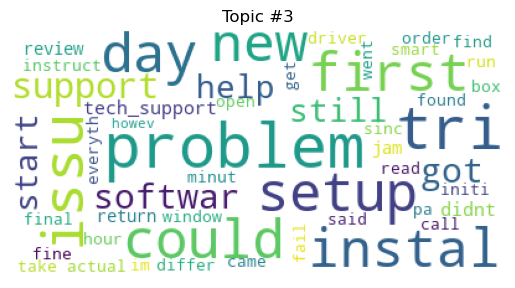

In [30]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(lda_model4.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(lda_model4.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### <font color=#FFB703> **Topic Modelling on Each Brand** </font>

<font color=#61BEB0>**Topic Modelling (HP):**</font>

In [52]:
hp_textlist = df_processed['Full review'][df_processed["Brand"]=="HP"].values.tolist()
hp_textlist_words = list(sent_to_words(hp_textlist))
hp_textlist_bigrams = make_bigrams(hp_textlist_words)

hp_dictionary = corpora.Dictionary(hp_textlist_bigrams)
hp_corpus = [hp_dictionary.doc2bow(text) for text in hp_textlist_bigrams]

In [53]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=hp_textlist_bigrams, dictionary=hp_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [54]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=hp_corpus, dictionary=hp_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_umass_hp.csv', index=False)
    pbar.close()


  0%|                                                                                          | 0/240 [06:47<?, ?it/s]

 55%|███████████████████████████████████████████▋                                    | 131/240 [23:04<20:21, 11.21s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [44:13<00:00, 11.06s/it]


In [55]:
lda_results = pd.read_csv("lda_tuning_results_umass_hp.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.215623
1       2  0.01                0.31  -2.115681
2       2  0.01                0.61  -2.371884
3       2  0.01  0.9099999999999999  -5.716229
4       2  0.01           symmetric  -2.390522

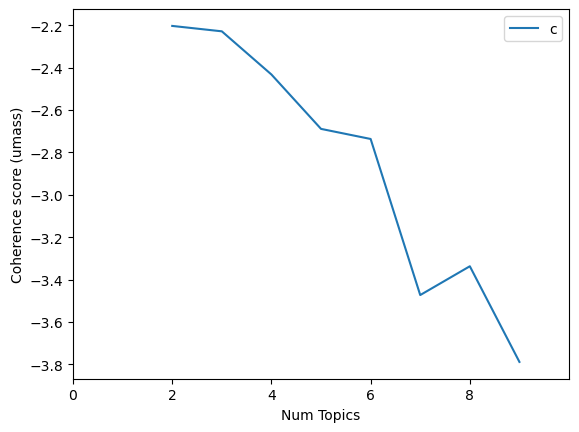

In [56]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [57]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
45       3  0.9099999999999999                0.01  -2.150350
40       3                0.61                0.01  -2.212822
36       3                0.31                0.31  -2.223912
54       3           symmetric           symmetric  -2.229131
39       3                0.31           symmetric  -2.231247
50       3           symmetric                0.01  -2.249503
51       3           symmetric                0.31  -2.262158
65       4                0.31                0.01  -2.280689
35       3                0.31                0.01  -2.287655
71       4                0.61                0.31  -2.293972
49       3  0.9099999999999999           symmetric  -2.298700
76       4  0.9099999999999999                0.31  -2.304529
70       4                0.61                0.01  -2.305391
31       3                0.01                0.31  -2.307110
79       4  0.9099999999999999           symmetric  -2.310729
34       3                0.01           symmetric  -2.313250
80       4           symmetric                0.01  -2.313980
75       4  0.9099999999999999                0.01  -2.318974
47       3  0.9099999999999999                0.61  -2.329823
41       3                0.61                0.31  -2.331251
44       3                0.61           symmetric  -2.341736
42       3                0.61                0.61  -2.348015
48       3  0.9099999999999999  0.9099999999999999  -2.351912
43       3                0.61  0.9099999999999999  -2.356398
37       3                0.31                0.61  -2.360885
67       4                0.31                0.61  -2.361139
78       4  0.9099999999999999  0.9099999999999999  -2.378046
52       3           symmetric                0.61  -2.381920
46       3  0.9099999999999999                0.31  -2.384992
74       4                0.61           symmetric  -2.386435
77       4  0.9099999999999999                0.61  -2.387596
69       4                0.31           symmetric  -2.396240
81       4           symmetric                0.31  -2.412907
66       4                0.31                0.31  -2.420133
84       4           symmetric           symmetric  -2.432812
53       3           symmetric  0.9099999999999999  -2.586794
72       4                0.61                0.61  -2.593339
30       3                0.01                0.01  -2.630440
60       4                0.01                0.01  -2.718506
64       4                0.01           symmetric  -2.771760
73       4                0.61  0.9099999999999999  -2.820519
85       4          asymmetric                0.01  -2.848987
55       3          asymmetric                0.01  -2.896065
38       3                0.31  0.9099999999999999  -3.050712
89       4          asymmetric           symmetric  -3.192478
56       3          asymmetric                0.31  -3.210453
59       3          asymmetric           symmetric  -3.523736
61       4                0.01                0.31  -3.647917
86       4          asymmetric                0.31  -3.704790
62       4                0.01                0.61  -3.854787
83       4           symmetric  0.9099999999999999  -4.802174
63       4                0.01  0.9099999999999999  -4.882124
82       4           symmetric                0.61  -5.594942
68       4                0.31  0.9099999999999999  -5.732283
33       3                0.01  0.9099999999999999  -6.065574
32       3                0.01                0.61  -6.186334
87       4          asymmetric                0.61  -7.171986
58       3          asymmetric  0.9099999999999999  -7.334290
57       3          asymmetric                0.61  -7.479992
88       4          asymmetric  0.9099999999999999  -9.155979

In [66]:
k= 3
a= 0.9099999999999999
b= 0.01

hp_lda_model3 = gensim.models.LdaModel(corpus=hp_corpus,
                                   id2word=hp_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [67]:
topics = hp_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.024*"app" + 0.019*"setup" + 0.018*"connect" + 0.018*"wifi" + 0.017*"comput" + 0.015*"scan" + 0.015*"time" + 0.015*"phone" + 0.015*"problem" + 0.013*"tri" + 0.013*"instal" + 0.012*"support" + 0.011*"softwar" + 0.011*"devic" + 0.010*"issu"')
(1, '0.031*"cartridg" + 0.023*"buy" + 0.019*"bought" + 0.017*"month" + 0.017*"purchas" + 0.015*"return" + 0.012*"tri" + 0.012*"page" + 0.012*"instant" + 0.012*"dont" + 0.011*"sign" + 0.010*"time" + 0.010*"never" + 0.009*"say" + 0.009*"even"')
(2, '0.027*"easi" + 0.020*"qualiti" + 0.016*"color" + 0.015*"realli" + 0.014*"featur" + 0.013*"price" + 0.013*"look" + 0.012*"make" + 0.011*"scanner" + 0.011*"home" + 0.010*"far" + 0.010*"lot" + 0.010*"old" + 0.010*"new" + 0.010*"copi"')


The 3 topics model appear somewhat similar to the topics derived from the overall model, but topic 3 is a little less clear in terms of intepretation.
- 0: setup/ installation
- 1: catridge lifespan
- 2: print/scan/photocopy quality


In [69]:
visual= pyLDAvis.gensim_models.prepare(hp_lda_model3, hp_corpus, hp_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.163447  0.242535       1        1  35.932341
1     -0.162344 -0.243083       2        1  33.907468
2      0.325791  0.000548       3        1  30.160191, topic_info=         Term         Freq        Total Category  logprob  loglift
340  cartridg  1719.000000  1719.000000  Default  30.0000  30.0000
43       easi  1329.000000  1329.000000  Default  29.0000  29.0000
95        app  1416.000000  1416.000000  Default  28.0000  28.0000
81        buy  1293.000000  1293.000000  Default  27.0000  27.0000
311   qualiti  1001.000000  1001.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
894      last   415.537925   485.774456   Topic3  -4.7923   1.0425
347  document   439.353192   580.057528   Topic3  -4.7366   0.9208
17        new   497.350451   854.971034   Topic3  -4.6126   0.6569
282      scan   455.300109  1361.191617   Topic3  -4.7009   0.1035
129      dont   391.720232  1127.427532   Topic3  -4.8513   0.1415

[172 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
394       1  0.891428       abl
394       2  0.108438       abl
394       3  0.001595       abl
616       1  0.939376   absolut
616       2  0.059909   absolut
...     ...       ...       ...
431       1  1.000408  wireless
107       1  0.691273   without
107       2  0.308867   without
433       1  0.018099      wont
433       2  0.982511      wont

[196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [70]:
fname = "lda_hp3"
print(fname)
hp_lda_model3.save(fname)

lda_hp3


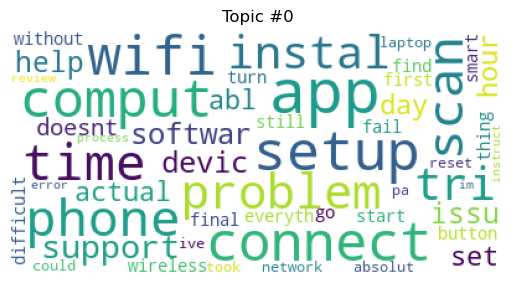

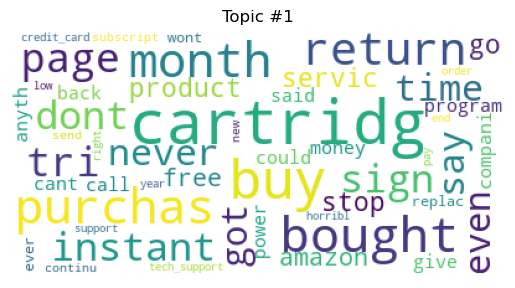

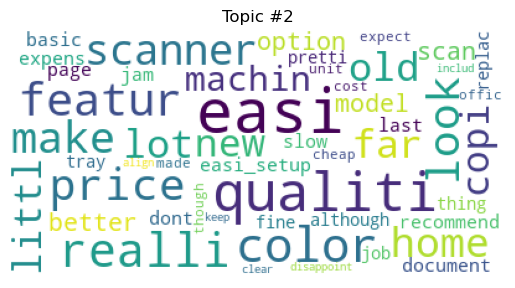

In [71]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(hp_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(hp_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

<font color=#61BEB0>**Topic Modelling (Epson):**</font>

In [92]:
ep_textlist = df_processed['Full review'][df_processed["Brand"]=="Epson"].values.tolist()
ep_textlist_words = list(sent_to_words(ep_textlist))
ep_textlist_bigrams = make_bigrams(ep_textlist_words)

ep_dictionary = corpora.Dictionary(ep_textlist_bigrams)
ep_corpus = [ep_dictionary.doc2bow(text) for text in ep_textlist_bigrams]

In [93]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=ep_textlist_bigrams, dictionary=ep_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [94]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=ep_corpus, dictionary=ep_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_umass_ep.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [21:48<00:00,  5.45s/it]


In [95]:
lda_results = pd.read_csv("lda_tuning_results_umass_ep.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.252432
1       2  0.01                0.31  -2.408296
2       2  0.01                0.61  -2.347532
3       2  0.01  0.9099999999999999  -3.351069
4       2  0.01           symmetric  -2.339975

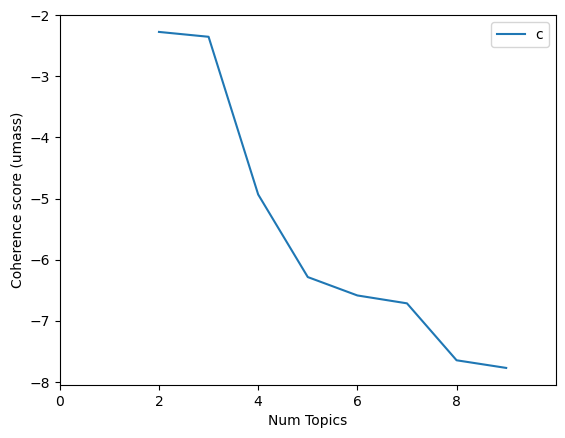

In [96]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [97]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
51       3           symmetric                0.31  -2.250465
45       3  0.9099999999999999                0.01  -2.303695
36       3                0.31                0.31  -2.336464
54       3           symmetric           symmetric  -2.352449
40       3                0.61                0.01  -2.397078
35       3                0.31                0.01  -2.440204
50       3           symmetric                0.01  -2.468306
55       3          asymmetric                0.01  -2.475988
49       3  0.9099999999999999           symmetric  -2.478695
46       3  0.9099999999999999                0.31  -2.519280
52       3           symmetric                0.61  -2.523173
58       3          asymmetric  0.9099999999999999  -3.542386
30       3                0.01                0.01  -3.813142
33       3                0.01  0.9099999999999999  -3.957341
57       3          asymmetric                0.61  -4.119830
48       3  0.9099999999999999  0.9099999999999999  -4.251176
38       3                0.31  0.9099999999999999  -4.479920
53       3           symmetric  0.9099999999999999  -4.505959
32       3                0.01                0.61  -4.580071
41       3                0.61                0.31  -4.812231
37       3                0.31                0.61  -4.893831
47       3  0.9099999999999999                0.61  -5.192641
44       3                0.61           symmetric  -5.209487
42       3                0.61                0.61  -5.229864
43       3                0.61  0.9099999999999999  -5.263774
31       3                0.01                0.31  -5.919186
56       3          asymmetric                0.31  -5.935650
59       3          asymmetric           symmetric  -6.065725
34       3                0.01           symmetric  -6.168325
39       3                0.31           symmetric  -6.239346

In [99]:
k= 3
a= "symmetric"
b= 0.31

ep_lda_model3 = gensim.models.LdaModel(corpus=ep_corpus,
                                   id2word=ep_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [100]:
topics = ep_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.011*"color" + 0.010*"say" + 0.009*"someth" + 0.009*"run" + 0.009*"time" + 0.009*"see" + 0.009*"black" + 0.008*"thing" + 0.008*"page" + 0.008*"sheet" + 0.007*"everi_time" + 0.007*"go" + 0.006*"except" + 0.005*"turn" + 0.005*"et"')
(1, '0.010*"product" + 0.009*"day" + 0.008*"cartridg" + 0.008*"buy" + 0.008*"updat" + 0.007*"solut" + 0.007*"replac" + 0.007*"issu" + 0.006*"connect" + 0.006*"brand" + 0.006*"tri" + 0.006*"amazon" + 0.006*"problem" + 0.006*"return" + 0.005*"time"')
(2, '0.009*"qualiti" + 0.008*"easi" + 0.007*"realli" + 0.007*"cartridg" + 0.005*"featur" + 0.005*"perfect" + 0.005*"color" + 0.005*"seem" + 0.005*"photo" + 0.005*"old" + 0.005*"far" + 0.004*"littl" + 0.004*"home" + 0.004*"copi" + 0.004*"especi"')


The 3 topics show some similarities to the 3 topics from the overall model but are more difficult to intepret.
- 0: ?
- 1: product return? setup?
- 2: print quality?



In [101]:
visual= pyLDAvis.gensim_models.prepare(ep_lda_model3, ep_corpus, ep_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.001622 -0.213652       1        1  42.405148
0     -0.195380  0.105490       2        1  30.190303
1      0.193758  0.108161       3        1  27.404549, topic_info=       Term        Freq       Total Category  logprob  loglift
606     day  206.000000  206.000000  Default  30.0000  30.0000
496  someth  240.000000  240.000000  Default  29.0000  29.0000
6      easi  279.000000  279.000000  Default  28.0000  28.0000
371     say  278.000000  278.000000  Default  27.0000  27.0000
320   updat  175.000000  175.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
57    month   85.758125  139.393243   Topic3  -5.5459   0.8087
441  bought  107.568681  275.713670   Topic3  -5.3193   0.3532
80     time  119.177565  418.106242   Topic3  -5.2168   0.0393
513  instal   83.257093  146.714187   Topic3  -5.5755   0.7279
114    even   77.557801  289.440069   Topic3  -5.6464  -0.0225

[202 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1125      1  0.716503          abl
1125      2  0.094277          abl
1125      3  0.194839          abl
587       1  0.994550     advertis
587       3  0.010694     advertis
...     ...       ...          ...
520       3  0.081184      without
521       2  0.990834  worth_money
36        1  0.603499         year
36        2  0.048066         year
36        3  0.347146         year

[286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [102]:
fname = "lda_ep3"
print(fname)
ep_lda_model3.save(fname)

lda_ep3


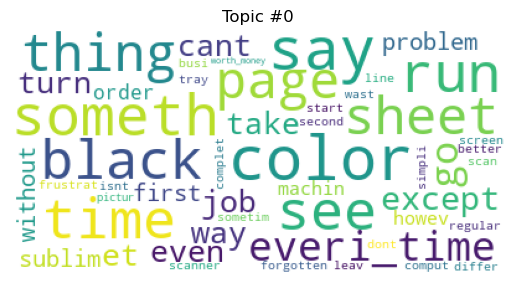

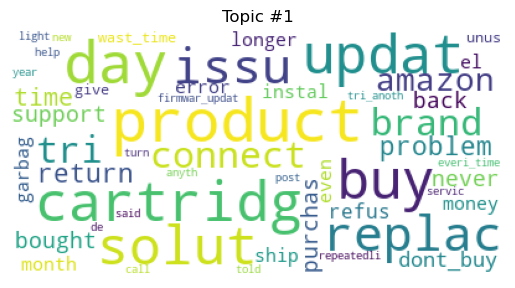

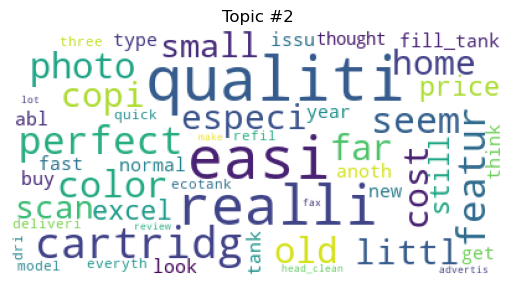

In [103]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(ep_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(ep_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

<font color=#61BEB0>**Topic Modelling (Canon):**</font>

In [104]:
ca_textlist = df_processed['Full review'][df_processed["Brand"]=="Canon"].values.tolist()
ca_textlist_words = list(sent_to_words(ca_textlist))
ca_textlist_bigrams = make_bigrams(ca_textlist_words)

ca_dictionary = corpora.Dictionary(ca_textlist_bigrams)
ca_corpus = [ca_dictionary.doc2bow(text) for text in ca_textlist_bigrams]

In [105]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=ca_textlist_bigrams, dictionary=ca_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [106]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=ca_corpus, dictionary=ca_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_umass_ca.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [17:16<00:00,  4.32s/it]


In [107]:
lda_results = pd.read_csv("lda_tuning_results_umass_ca.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.313653
1       2  0.01                0.31  -2.268522
2       2  0.01                0.61  -2.313950
3       2  0.01  0.9099999999999999  -2.447702
4       2  0.01           symmetric  -2.309719

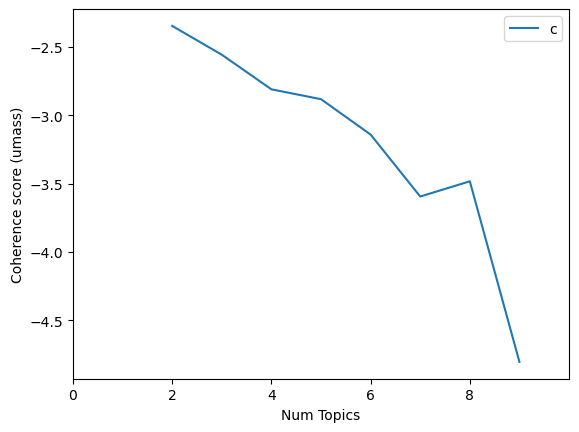

In [108]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [109]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
44       3                0.61           symmetric  -2.388191
40       3                0.61                0.01  -2.418342
41       3                0.61                0.31  -2.433387
45       3  0.9099999999999999                0.01  -2.453767
50       3           symmetric                0.01  -2.459838
46       3  0.9099999999999999                0.31  -2.460711
49       3  0.9099999999999999           symmetric  -2.460874
35       3                0.31                0.01  -2.475196
71       4                0.61                0.31  -2.480465
80       4           symmetric                0.01  -2.495628
75       4  0.9099999999999999                0.01  -2.496232
70       4                0.61                0.01  -2.499351
47       3  0.9099999999999999                0.61  -2.508041
69       4                0.31           symmetric  -2.521023
66       4                0.31                0.31  -2.521946
42       3                0.61                0.61  -2.521992
65       4                0.31                0.01  -2.525750
31       3                0.01                0.31  -2.527957
51       3           symmetric                0.31  -2.537168
74       4                0.61           symmetric  -2.543427
36       3                0.31                0.31  -2.552162
54       3           symmetric           symmetric  -2.557107
39       3                0.31           symmetric  -2.557748
81       4           symmetric                0.31  -2.558362
55       3          asymmetric                0.01  -2.587610
76       4  0.9099999999999999                0.31  -2.592925
34       3                0.01           symmetric  -2.603395
79       4  0.9099999999999999           symmetric  -2.622191
77       4  0.9099999999999999                0.61  -2.624669
56       3          asymmetric                0.31  -2.801456
84       4           symmetric           symmetric  -2.810352
59       3          asymmetric           symmetric  -2.844206
60       4                0.01                0.01  -2.952823
85       4          asymmetric                0.01  -2.981473
30       3                0.01                0.01  -3.003794
48       3  0.9099999999999999  0.9099999999999999  -3.035694
64       4                0.01           symmetric  -3.261956
89       4          asymmetric           symmetric  -3.580967
52       3           symmetric                0.61  -3.642439
61       4                0.01                0.31  -3.776605
37       3                0.31                0.61  -3.791069
86       4          asymmetric                0.31  -3.903925
72       4                0.61                0.61  -3.953356
43       3                0.61  0.9099999999999999  -5.444572
78       4  0.9099999999999999  0.9099999999999999  -6.668488
67       4                0.31                0.61  -8.175274
82       4           symmetric                0.61  -8.207977
33       3                0.01  0.9099999999999999  -8.282306
58       3          asymmetric  0.9099999999999999  -8.886494
73       4                0.61  0.9099999999999999  -8.969470
32       3                0.01                0.61  -9.144441
53       3           symmetric  0.9099999999999999  -9.151640
87       4          asymmetric                0.61  -9.308257
57       3          asymmetric                0.61  -9.338489
38       3                0.31  0.9099999999999999  -9.375785
68       4                0.31  0.9099999999999999 -10.909236
83       4           symmetric  0.9099999999999999 -11.009486
63       4                0.01  0.9099999999999999 -11.237417
62       4                0.01                0.61 -12.882447
88       4          asymmetric  0.9099999999999999 -13.160870

In [110]:
k= 4
a= 0.61
b= 0.3

ca_lda_model4= gensim.models.LdaModel(corpus=ca_corpus,
                                   id2word=ca_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [111]:
topics = ca_lda_model4.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.010*"time" + 0.008*"jam" + 0.008*"new" + 0.008*"problem" + 0.007*"year" + 0.007*"buy" + 0.007*"got" + 0.006*"copi" + 0.006*"page" + 0.006*"cartridg" + 0.006*"anoth" + 0.006*"last" + 0.006*"even" + 0.005*"still" + 0.005*"tri"')
(1, '0.015*"product" + 0.014*"return" + 0.011*"support" + 0.010*"tech_support" + 0.008*"amazon" + 0.008*"help" + 0.008*"tri" + 0.007*"cannon" + 0.007*"dont_buy" + 0.007*"call" + 0.006*"couldnt" + 0.006*"instruct" + 0.006*"receiv" + 0.005*"buy" + 0.005*"comput"')
(2, '0.015*"easi" + 0.011*"qualiti" + 0.010*"scan" + 0.010*"photo" + 0.009*"turn" + 0.009*"price" + 0.008*"scanner" + 0.008*"cartridg" + 0.008*"time" + 0.007*"featur" + 0.006*"tray" + 0.006*"cheap" + 0.006*"run" + 0.006*"far" + 0.005*"job"')
(3, '0.016*"connect" + 0.014*"wireless" + 0.012*"wifi" + 0.012*"setup" + 0.009*"instal" + 0.007*"phone" + 0.007*"laptop" + 0.007*"devic" + 0.006*"come" + 0.006*"cabl" + 0.006*"fine" + 0.005*"app" + 0.005*"network" + 0.005*"softwar" + 0.005*"fail"')


The 4 topics has similarities with some of the topics derived from the overall model:
- 0: catridge lifespan, printer jam
- 1: customer support, amazon returns
- 2: print/scan quality
- 3: set-up/installation/connecting to other devices


In [112]:
visual= pyLDAvis.gensim_models.prepare(ca_lda_model4, ca_corpus, ca_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.134536  0.078774       1        1  32.245467
2     -0.145909  0.005898       2        1  26.376655
3      0.077069 -0.227056       3        1  24.136579
1      0.203376  0.142384       4        1  17.241299, topic_info=         Term        Freq       Total Category  logprob  loglift
360   connect  215.000000  215.000000  Default  30.0000  30.0000
230  wireless  192.000000  192.000000  Default  29.0000  29.0000
301      easi  242.000000  242.000000  Default  28.0000  28.0000
227   product  148.000000  148.000000  Default  27.0000  27.0000
184     setup  157.000000  157.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
474     first   40.014756  153.077715   Topic4  -5.4640   0.4162
253     money   36.005756   92.456541   Topic4  -5.5696   0.8148
348    doesnt   37.762217  143.150837   Topic4  -5.5219   0.4253
307    window   34.454733   76.623939   Topic4  -5.6136   0.9586
68         go   35.249140  164.765964   Topic4  -5.5908   0.2158

[251 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
289       3  0.961738     absolut
27        2  0.977407         add
17        1  0.025121       allow
17        2  0.025121       allow
17        3  0.954616       allow
...     ...       ...         ...
231       3  0.976074  wirelessli
333       4  0.975074  worst_ever
1142      1  0.956023       worth
1142      3  0.040682       worth
59        1  0.992680        year

[351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [113]:
fname = "lda_ca4"
print(fname)
ca_lda_model4.save(fname)

lda_ca4


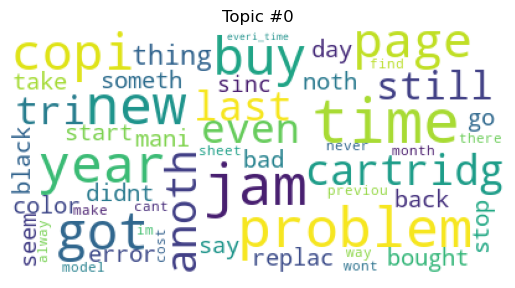

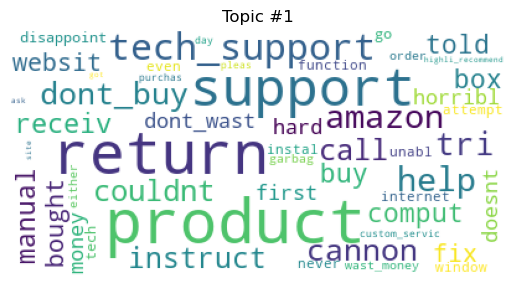

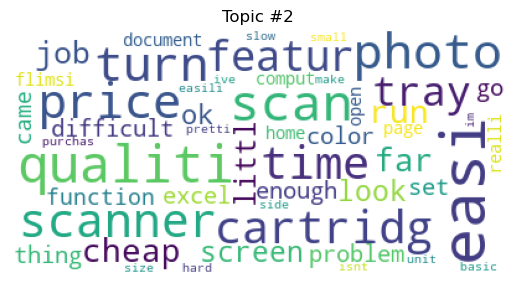

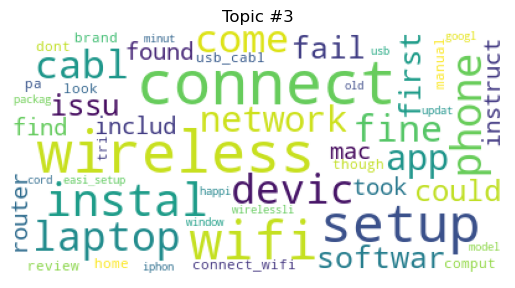

In [114]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(ca_lda_model4.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(ca_lda_model4.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### <font color=#FFB703> **Topic Modelling by Review Sentiment** </font>

<font color=#61BEB0>**Topic Modelling (Positive Reviews):**</font>

In [129]:
pve_textlist = df_processed['Full review'][df_processed['Review rating']>=4].values.tolist()
pve_textlist_words = list(sent_to_words(pve_textlist))
pve_textlist_bigrams = make_bigrams(pve_textlist_words)

pve_dictionary = corpora.Dictionary(pve_textlist_bigrams)
pve_corpus = [pve_dictionary.doc2bow(text) for text in pve_textlist_bigrams]

In [130]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=pve_textlist_bigrams, dictionary=pve_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [131]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=pve_corpus, dictionary=pve_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_umass_pve.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [33:46<00:00,  8.44s/it]


In [132]:
lda_results = pd.read_csv("lda_tuning_results_umass_pve.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.325642
1       2  0.01                0.31  -2.265183
2       2  0.01                0.61  -3.128218
3       2  0.01  0.9099999999999999  -4.458942
4       2  0.01           symmetric  -2.309320

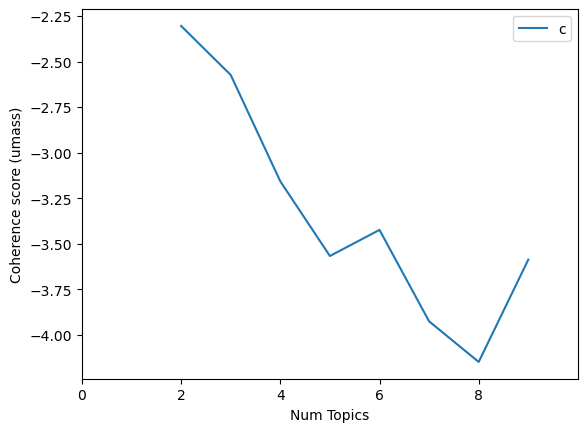

In [133]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [134]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==2) | (lda_results["Topics"]==3)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
16       2  0.9099999999999999                0.31  -2.221574
19       2  0.9099999999999999           symmetric  -2.225554
29       2          asymmetric           symmetric  -2.231344
26       2          asymmetric                0.31  -2.238679
14       2                0.61           symmetric  -2.252538
7        2                0.31                0.61  -2.254105
27       2          asymmetric                0.61  -2.255656
21       2           symmetric                0.31  -2.257237
1        2                0.01                0.31  -2.265183
12       2                0.61                0.61  -2.277895
22       2           symmetric                0.61  -2.280507
11       2                0.61                0.31  -2.281081
17       2  0.9099999999999999                0.61  -2.283679
6        2                0.31                0.31  -2.284095
5        2                0.31                0.01  -2.287611
9        2                0.31           symmetric  -2.294313
24       2           symmetric           symmetric  -2.304037
4        2                0.01           symmetric  -2.309320
15       2  0.9099999999999999                0.01  -2.319470
20       2           symmetric                0.01  -2.321944
0        2                0.01                0.01  -2.325642
35       3                0.31                0.01  -2.355177
10       2                0.61                0.01  -2.356202
36       3                0.31                0.31  -2.360246
51       3           symmetric                0.31  -2.363795
45       3  0.9099999999999999                0.01  -2.365823
50       3           symmetric                0.01  -2.367139
46       3  0.9099999999999999                0.31  -2.386017
49       3  0.9099999999999999           symmetric  -2.387567
40       3                0.61                0.01  -2.399768
31       3                0.01                0.31  -2.424653
30       3                0.01                0.01  -2.440784
18       2  0.9099999999999999  0.9099999999999999  -2.454525
25       2          asymmetric                0.01  -2.460747
39       3                0.31           symmetric  -2.481324
54       3           symmetric           symmetric  -2.573337
34       3                0.01           symmetric  -2.579028
41       3                0.61                0.31  -2.890859
44       3                0.61           symmetric  -2.978069
55       3          asymmetric                0.01  -2.999022
2        2                0.01                0.61  -3.128218
42       3                0.61                0.61  -3.350627
47       3  0.9099999999999999                0.61  -3.479530
32       3                0.01                0.61  -3.629439
48       3  0.9099999999999999  0.9099999999999999  -3.657920
23       2           symmetric  0.9099999999999999  -3.885507
13       2                0.61  0.9099999999999999  -3.950468
8        2                0.31  0.9099999999999999  -3.964200
59       3          asymmetric           symmetric  -3.980662
56       3          asymmetric                0.31  -4.143381
3        2                0.01  0.9099999999999999  -4.458942
28       2          asymmetric  0.9099999999999999  -4.526268
52       3           symmetric                0.61  -4.536474
37       3                0.31                0.61  -4.770623
57       3          asymmetric                0.61  -5.251236
43       3                0.61  0.9099999999999999  -5.257705
53       3           symmetric  0.9099999999999999  -7.019600
38       3                0.31  0.9099999999999999  -7.343829
58       3          asymmetric  0.9099999999999999  -8.061040
33       3                0.01  0.9099999999999999  -8.618587

In [135]:
k= 2
a= 0.9099999999999999
b= 0.31

pve_lda_model2 = gensim.models.LdaModel(corpus=pve_corpus,
                                   id2word=pve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [136]:
topics = pve_lda_model2.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.008*"cartridg" + 0.005*"color" + 0.005*"time" + 0.005*"page" + 0.005*"dont" + 0.005*"featur" + 0.005*"scan" + 0.004*"make" + 0.004*"go" + 0.004*"thing" + 0.004*"even" + 0.004*"replac" + 0.004*"photo" + 0.004*"year" + 0.004*"month"')
(1, '0.026*"easi" + 0.013*"qualiti" + 0.012*"wifi" + 0.009*"product" + 0.009*"far" + 0.008*"setup" + 0.008*"excel" + 0.008*"phone" + 0.007*"price" + 0.007*"easi_setup" + 0.007*"instal" + 0.007*"wireless" + 0.007*"everyth" + 0.006*"home" + 0.006*"app"')


The topics are not very eary to intepret as the top words are not clearly related to each other and there are some words that are not helpful.
- 0: catridge lifespan?
- 1: product quality? set-up?


In [137]:
fname = "lda_pve2"
print(fname)
pve_lda_model2.save(fname)

lda_pve2


In [138]:
#try 3 topics
k= 3
a= 0.01

pve_lda_model3 = gensim.models.LdaModel(corpus=pve_corpus,
                                   id2word=pve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [139]:
topics = pve_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.009*"app" + 0.008*"color" + 0.007*"easi" + 0.007*"page" + 0.007*"scan" + 0.007*"photo" + 0.007*"phone" + 0.006*"tri" + 0.006*"featur" + 0.005*"first" + 0.005*"setup" + 0.005*"look" + 0.005*"scanner" + 0.005*"set" + 0.005*"realli"')
(1, '0.017*"easi" + 0.010*"qualiti" + 0.010*"wifi" + 0.009*"old" + 0.009*"far" + 0.009*"product" + 0.009*"connect" + 0.008*"copi" + 0.008*"price" + 0.007*"excel" + 0.007*"setup" + 0.007*"say" + 0.007*"easi_setup" + 0.007*"money" + 0.006*"problem"')
(2, '0.012*"cartridg" + 0.011*"issu" + 0.010*"bought" + 0.010*"home" + 0.008*"replac" + 0.007*"qualiti" + 0.007*"wireless" + 0.007*"everyth" + 0.007*"purchas" + 0.007*"fast" + 0.006*"run" + 0.006*"job" + 0.006*"easi" + 0.006*"new" + 0.006*"month"')


The topics appear a little mixed, but are clearer than the 2 topic model
- 0: printing/scanning with phone app?
- 1: setup
- 2: caridge lifespan?

In [140]:
visual= pyLDAvis.gensim_models.prepare(pve_lda_model3, pve_corpus, pve_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.029956 -0.229643       1        1  42.974894
2     -0.231469  0.090990       2        1  31.939791
1      0.201513  0.138653       3        1  25.085315, topic_info=         Term        Freq       Total Category  logprob  loglift
315      issu  358.000000  358.000000  Default  30.0000  30.0000
188    bought  348.000000  348.000000  Default  29.0000  29.0000
334      home  332.000000  332.000000  Default  28.0000  28.0000
402       old  250.000000  250.000000  Default  27.0000  27.0000
241   connect  229.000000  229.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
63   function  124.361009  209.742041   Topic3  -5.3694   0.8602
204      look  130.217752  361.405853   Topic3  -5.3234   0.3621
17      littl  123.034687  297.278375   Topic3  -5.3802   0.5007
59     comput  120.130665  297.982195   Topic3  -5.4040   0.4744
147    realli  119.943668  334.782784   Topic3  -5.4056   0.3564

[179 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1491      1  0.988589        ad
1278      1  0.991239       add
57        1  0.997124     allow
40        1  0.935766       app
40        3  0.064536       app
...     ...       ...       ...
363       2  0.997994  wireless
37        1  0.291670      year
37        2  0.708342      year
396       3  0.993278       yet
135       2  0.994194      your

[205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [141]:
fname = "lda_pve3"
print(fname)
pve_lda_model3.save(fname)

lda_pve3


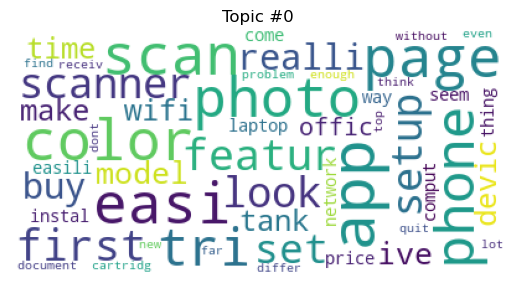

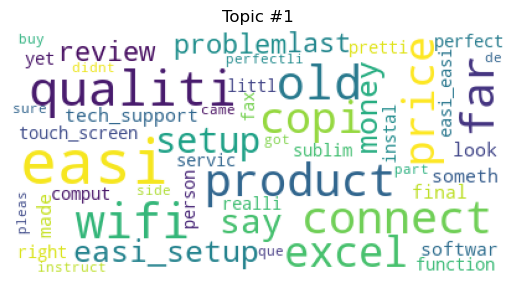

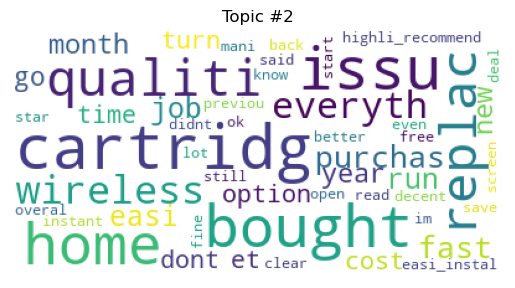

In [142]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(pve_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(pve_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

<font color=#61BEB0>**Topic Modelling (Negative Reviews):**</font>

In [143]:
nve_textlist = df_processed['Full review'][df_processed['Review rating']<=2].values.tolist()
nve_textlist_words = list(sent_to_words(nve_textlist))
nve_textlist_bigrams = make_bigrams(nve_textlist_words)

nve_dictionary = corpora.Dictionary(nve_textlist_bigrams)
nve_corpus = [nve_dictionary.doc2bow(text) for text in nve_textlist_bigrams]

In [144]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=nve_textlist_bigrams, dictionary=nve_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [145]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=nve_corpus, dictionary=nve_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_umass_nve.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [38:03<00:00,  9.51s/it]


In [146]:
lda_results = pd.read_csv("lda_tuning_results_umass_nve.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.124585
1       2  0.01                0.31  -2.058515
2       2  0.01                0.61  -2.143281
3       2  0.01  0.9099999999999999  -2.168810
4       2  0.01           symmetric  -2.027283

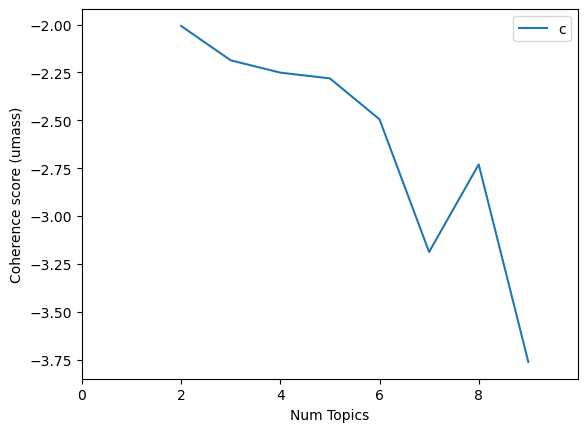

In [147]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [148]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
42       3                0.61                0.61  -2.109513
43       3                0.61  0.9099999999999999  -2.140642
46       3  0.9099999999999999                0.31  -2.143895
37       3                0.31                0.61  -2.144900
52       3           symmetric                0.61  -2.148983
47       3  0.9099999999999999                0.61  -2.152429
66       4                0.31                0.31  -2.154005
49       3  0.9099999999999999           symmetric  -2.157238
41       3                0.61                0.31  -2.162343
44       3                0.61           symmetric  -2.167463
51       3           symmetric                0.31  -2.179167
36       3                0.31                0.31  -2.181055
54       3           symmetric           symmetric  -2.186947
39       3                0.31           symmetric  -2.187223
30       3                0.01                0.01  -2.193077
48       3  0.9099999999999999  0.9099999999999999  -2.194627
40       3                0.61                0.01  -2.202311
50       3           symmetric                0.01  -2.219189
56       3          asymmetric                0.31  -2.221121
35       3                0.31                0.01  -2.232070
31       3                0.01                0.31  -2.232600
59       3          asymmetric           symmetric  -2.234486
45       3  0.9099999999999999                0.01  -2.239287
69       4                0.31           symmetric  -2.239670
34       3                0.01           symmetric  -2.242016
70       4                0.61                0.01  -2.246732
78       4  0.9099999999999999  0.9099999999999999  -2.246811
84       4           symmetric           symmetric  -2.251144
81       4           symmetric                0.31  -2.251387
72       4                0.61                0.61  -2.256347
55       3          asymmetric                0.01  -2.277021
77       4  0.9099999999999999                0.61  -2.285170
75       4  0.9099999999999999                0.01  -2.285625
71       4                0.61                0.31  -2.289442
76       4  0.9099999999999999                0.31  -2.297081
60       4                0.01                0.01  -2.303194
74       4                0.61           symmetric  -2.308820
79       4  0.9099999999999999           symmetric  -2.328934
85       4          asymmetric                0.01  -2.332343
65       4                0.31                0.01  -2.357245
57       3          asymmetric                0.61  -2.359178
80       4           symmetric                0.01  -2.366994
73       4                0.61  0.9099999999999999  -2.373924
89       4          asymmetric           symmetric  -2.444301
64       4                0.01           symmetric  -2.460361
61       4                0.01                0.31  -2.460485
86       4          asymmetric                0.31  -2.953177
67       4                0.31                0.61  -3.201925
82       4           symmetric                0.61  -3.444404
32       3                0.01                0.61  -4.894371
68       4                0.31  0.9099999999999999  -5.289312
62       4                0.01                0.61  -5.683461
87       4          asymmetric                0.61  -6.222665
88       4          asymmetric  0.9099999999999999  -6.453869
58       3          asymmetric  0.9099999999999999  -6.825523
38       3                0.31  0.9099999999999999  -7.415334
53       3           symmetric  0.9099999999999999  -7.518633
33       3                0.01  0.9099999999999999  -7.539741
83       4           symmetric  0.9099999999999999  -7.813429
63       4                0.01  0.9099999999999999 -10.741079

In [149]:
k= 3
a= 0.61
b= 0.61

nve_lda_model3 = gensim.models.LdaModel(corpus=nve_corpus,
                                   id2word=nve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [150]:
topics = nve_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.012*"time" + 0.010*"page" + 0.007*"thing" + 0.007*"tri" + 0.007*"qualiti" + 0.006*"color" + 0.005*"bought" + 0.005*"jam" + 0.005*"buy" + 0.005*"even" + 0.005*"back" + 0.005*"photo" + 0.004*"go" + 0.004*"job" + 0.004*"doesnt"')
(1, '0.019*"cartridg" + 0.009*"buy" + 0.008*"purchas" + 0.008*"replac" + 0.007*"return" + 0.006*"support" + 0.006*"amazon" + 0.006*"bought" + 0.006*"month" + 0.005*"call" + 0.005*"compani" + 0.005*"servic" + 0.005*"problem" + 0.005*"product" + 0.005*"new"')
(2, '0.014*"scan" + 0.012*"comput" + 0.010*"app" + 0.009*"connect" + 0.009*"softwar" + 0.007*"wifi" + 0.006*"wireless" + 0.006*"tri" + 0.006*"setup" + 0.006*"devic" + 0.005*"instal" + 0.005*"scanner" + 0.005*"network" + 0.004*"phone" + 0.004*"smart"')


Topics are not very intepretable. There probably needs to be further removal of opinion words to get clear and meaningful topics.

In [151]:
visual= pyLDAvis.gensim_models.prepare(nve_lda_model3, nve_corpus, nve_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.007091 -0.149137       1        1  39.788411
2     -0.136674  0.080225       2        1  30.352213
1      0.143765  0.068912       3        1  29.859376, topic_info=         Term        Freq       Total Category  logprob  loglift
325  cartridg  853.000000  853.000000  Default  30.0000  30.0000
693      scan  696.000000  696.000000  Default  29.0000  29.0000
85     comput  549.000000  549.000000  Default  28.0000  28.0000
79        app  474.000000  474.000000  Default  27.0000  27.0000
86    connect  434.000000  434.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
59      never  164.093845  412.183182   Topic3  -5.6165   0.2876
284       got  158.943898  370.048583   Topic3  -5.6484   0.3636
14        tri  188.565964  888.461554   Topic3  -5.4775  -0.3414
147      even  171.590138  661.655882   Topic3  -5.5719  -0.1410
72        say  145.425491  428.640092   Topic3  -5.7373   0.1277

[213 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3622      1  0.016212       agent
3622      2  0.016212       agent
3622      3  0.972708       agent
322       1  0.982089       align
322       2  0.009628       align
...     ...       ...         ...
78        2  0.405125     without
78        3  0.276603     without
601       1  0.981410  worst_ever
601       2  0.007851  worst_ever
601       3  0.007851  worst_ever

[513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [154]:
fname = "lda_nve3"
print(fname)
nve_lda_model3.save(fname)

lda_nve3


In [155]:
#try 4 topics
k= 4
a= 0.31
b= 0.31

nve_lda_model4 = gensim.models.LdaModel(corpus=nve_corpus,
                                   id2word=nve_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [156]:
topics = nve_lda_model4.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.016*"time" + 0.010*"page" + 0.010*"thing" + 0.010*"tri" + 0.009*"jam" + 0.007*"buy" + 0.007*"back" + 0.007*"job" + 0.006*"everi_time" + 0.006*"bought" + 0.006*"doesnt" + 0.006*"money" + 0.005*"im" + 0.005*"tray" + 0.005*"problem"')
(1, '0.013*"cartridg" + 0.011*"return" + 0.010*"support" + 0.010*"problem" + 0.009*"help" + 0.009*"replac" + 0.008*"amazon" + 0.008*"purchas" + 0.008*"call" + 0.008*"said" + 0.007*"issu" + 0.006*"day" + 0.006*"box" + 0.006*"tech_support" + 0.006*"new"')
(2, '0.009*"scan" + 0.009*"app" + 0.009*"comput" + 0.008*"softwar" + 0.007*"connect" + 0.006*"tri" + 0.006*"even" + 0.006*"buy" + 0.005*"wireless" + 0.005*"dont" + 0.005*"devic" + 0.005*"cant" + 0.005*"wifi" + 0.004*"without" + 0.004*"way"')
(3, '0.019*"color" + 0.018*"qualiti" + 0.011*"photo" + 0.011*"cartridg" + 0.010*"scan" + 0.009*"copi" + 0.009*"black" + 0.008*"machin" + 0.007*"slow" + 0.006*"page" + 0.006*"document" + 0.006*"disappoint" + 0.006*"cost" + 0.005*"scanner" + 0.005*"low"')


- 0:?
- 1: tech support, amazon returns?
- 2: connecting to other devices
- 3: print quality, user experience?

In [157]:
fname = "lda_nve4"
print(fname)
nve_lda_model4.save(fname)

lda_nve4


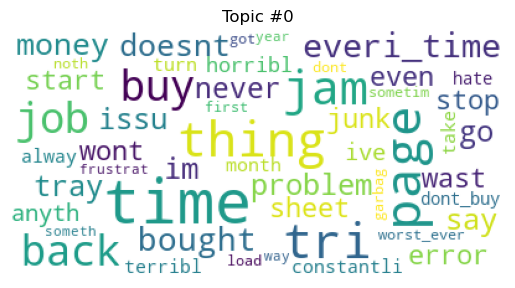

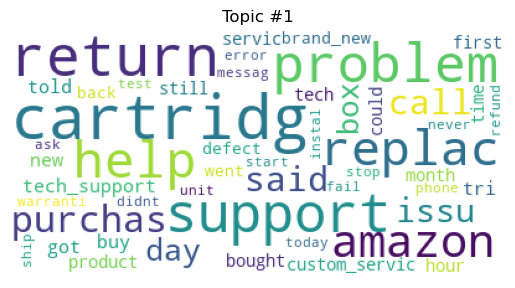

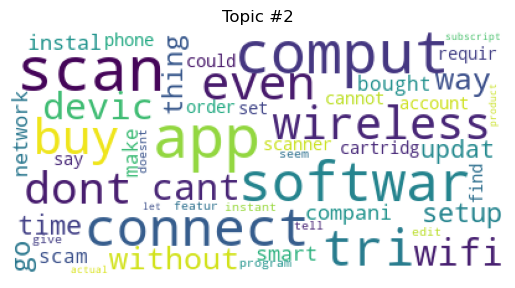

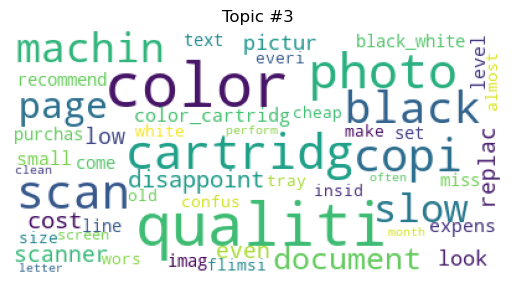

In [158]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(nve_lda_model4.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(nve_lda_model4.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

<font color=#61BEB0>**Topic Modelling (Neutral Reviews):**</font>

In [159]:
neu_textlist = df_processed['Full review'][df_processed['Review rating']==3].values.tolist()
neu_textlist_words = list(sent_to_words(neu_textlist))
neu_textlist_bigrams = make_bigrams(neu_textlist_words)

neu_dictionary = corpora.Dictionary(neu_textlist_bigrams)
neu_corpus = [neu_dictionary.doc2bow(text) for text in neu_textlist_bigrams]

In [160]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=neu_textlist_bigrams, dictionary=neu_dictionary, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [161]:
#run over different combinations of hyper parameters k (number of topics), alpha (document-topic density), eta (word-topic density)
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Eta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(eta)*len(alpha)*len(topics_range)))
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through eta values
            for b in eta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=neu_corpus, dictionary=neu_dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Eta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_umass_neu.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [12:22<00:00,  3.09s/it]


In [162]:
lda_results = pd.read_csv("lda_tuning_results_umass_neu.csv")
lda_results.head()

Topics Alpha                 Eta  Coherence
0       2  0.01                0.01  -2.900666
1       2  0.01                0.31  -2.833642
2       2  0.01                0.61  -5.961738
3       2  0.01  0.9099999999999999  -9.903508
4       2  0.01           symmetric  -4.569567

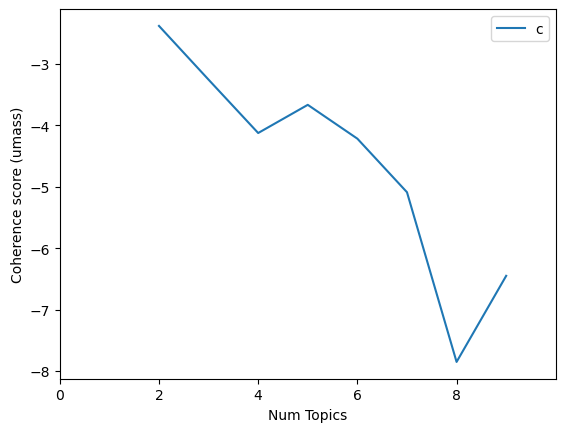

In [163]:
#use default alpha and eta to find number of topics
findk = lda_results[(lda_results["Alpha"]=="symmetric") & (lda_results["Eta"]=="symmetric")]

x = range(min_topics, max_topics, step_size)
plt.plot(findk["Topics"], findk["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (umass)")
plt.legend(("coherence_values"), loc='best')
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, step=2))
plt.show()

In [167]:
#choose alpha and eta values by highest coherence score
findhyp = lda_results[(lda_results["Topics"]==3) | (lda_results["Topics"]==4)]| (lda_results["Topics"]==5)
findhyp.sort_values(by="Coherence", ascending=False)

Topics               Alpha                 Eta  Coherence
40        3                0.61                0.01  -2.346592
70        4                0.61                0.01  -2.368984
45        3  0.9099999999999999                0.01  -2.414438
75        4  0.9099999999999999                0.01  -2.440695
105       5  0.9099999999999999                0.01  -2.445299
..      ...                 ...                 ...        ...
53        3           symmetric  0.9099999999999999  -9.700639
112       5           symmetric                0.61  -9.757011
38        3                0.31  0.9099999999999999 -10.285669
93        5                0.01  0.9099999999999999 -10.549542
113       5           symmetric  0.9099999999999999 -11.112355

[90 rows x 4 columns]

In [165]:
#try 3 topics
k= 3
a= 0.61
b= 0.01

neu_lda_model3 = gensim.models.LdaModel(corpus=neu_corpus,
                                   id2word=neu_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [166]:
topics = neu_lda_model3.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.039*"cartridg" + 0.022*"qualiti" + 0.016*"dont" + 0.016*"better" + 0.015*"year" + 0.015*"replac" + 0.015*"purchas" + 0.015*"color" + 0.013*"cheap" + 0.013*"lot" + 0.013*"keep" + 0.012*"bought" + 0.012*"copi" + 0.011*"month" + 0.011*"price"')
(1, '0.016*"tri" + 0.016*"time" + 0.013*"still" + 0.013*"new" + 0.012*"comput" + 0.012*"got" + 0.011*"instal" + 0.010*"thing" + 0.010*"wireless" + 0.010*"scan" + 0.010*"even" + 0.009*"without" + 0.009*"jam" + 0.009*"make" + 0.009*"app"')
(2, '0.014*"wifi" + 0.013*"photo" + 0.013*"tech_support" + 0.012*"scan" + 0.012*"page" + 0.012*"dont" + 0.011*"light" + 0.011*"scanner" + 0.011*"doesnt" + 0.011*"difficult" + 0.010*"help" + 0.009*"run" + 0.009*"side" + 0.009*"find" + 0.009*"im"')


Topics are not very intepretable. There probably needs to be further removal of opinion words to get clear and meaningful topics.

- 0: print quality? catridge lifespan? value for money?
- 1: installation
- 2: ?

In [168]:
visual= pyLDAvis.gensim_models.prepare(neu_lda_model3, neu_corpus, neu_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.179925  0.236235       1        1  38.595463
2     -0.159622 -0.245844       2        1  33.022407
0      0.339547  0.009609       3        1  28.382130, topic_info=         Term        Freq       Total Category  logprob  loglift
138  cartridg  475.000000  475.000000  Default  30.0000  30.0000
232   qualiti  284.000000  284.000000  Default  29.0000  29.0000
642    better  192.000000  192.000000  Default  28.0000  28.0000
112      year  185.000000  185.000000  Default  27.0000  27.0000
678    replac  183.000000  183.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
328      look  106.620157  136.943940   Topic3  -4.7524   1.0091
310    realli  105.789413  142.253291   Topic3  -4.7603   0.9633
431     howev   98.876898  157.352724   Topic3  -4.8278   0.7948
43       easi  103.076834  215.808132   Topic3  -4.7862   0.5205
161     could   99.408737  197.630955   Topic3  -4.8225   0.5722

[181 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
361       1  0.998256       abl
561       2  1.002934       add
83        1  0.619261       app
83        2  0.381736       app
1175      2  0.995664   automat
...     ...       ...       ...
267       2  1.002336      wifi
133       1  0.999598    window
134       1  0.996966  wireless
286       1  0.997330   without
112       3  0.997515      year

[209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [170]:
fname = "lda_neu3"
print(fname)
neu_lda_model3.save(fname)

lda_neu3


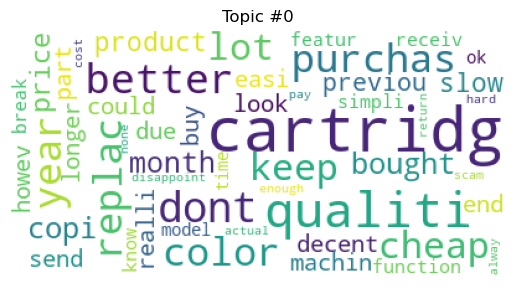

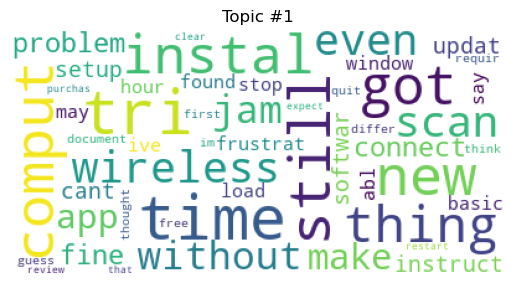

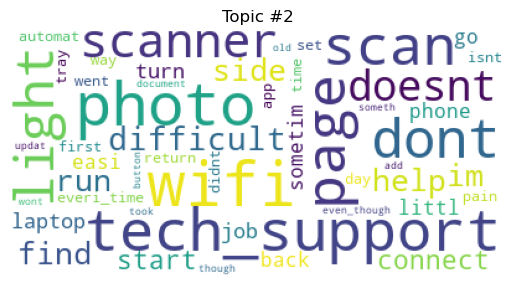

In [169]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(neu_lda_model3.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(neu_lda_model3.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [171]:
#try 5 topics
k= 5
a= 0.9099999999999999
b= 0.01

neu_lda_model5 = gensim.models.LdaModel(corpus=neu_corpus,
                                   id2word=neu_dictionary,
                                   num_topics=k, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   alpha=a,
                                   eta=b)

In [172]:
topics = neu_lda_model5.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.062*"cartridg" + 0.025*"bought" + 0.024*"color" + 0.022*"disappoint" + 0.021*"keep" + 0.020*"seem" + 0.019*"copi" + 0.019*"purchas" + 0.019*"product" + 0.018*"lot" + 0.018*"look" + 0.016*"issu" + 0.016*"sure" + 0.016*"old" + 0.015*"decent"')
(1, '0.029*"comput" + 0.022*"instal" + 0.020*"setup" + 0.020*"app" + 0.019*"wireless" + 0.018*"connect" + 0.018*"without" + 0.016*"instruct" + 0.016*"softwar" + 0.014*"hour" + 0.013*"frustrat" + 0.013*"window" + 0.013*"tri" + 0.013*"found" + 0.012*"abl"')
(2, '0.034*"scan" + 0.022*"photo" + 0.020*"wifi" + 0.019*"doesnt" + 0.019*"tech_support" + 0.018*"page" + 0.017*"turn" + 0.016*"cant" + 0.016*"say" + 0.016*"scanner" + 0.015*"job" + 0.015*"im" + 0.014*"littl" + 0.014*"document" + 0.014*"go"')
(3, '0.024*"fine" + 0.023*"still" + 0.022*"updat" + 0.021*"time" + 0.018*"dont" + 0.017*"think" + 0.016*"stop" + 0.016*"jam" + 0.014*"month" + 0.013*"tri" + 0.013*"first" + 0.013*"purchas" + 0.013*"part" + 0.011*"may" + 0.011*"cheap"')
(4, '0.039*"qual

Topics are not very intepretable. 

- 0: ?
- 1: set-up and installation
- 2: user experience
- 3: ?
- 4: ?

In [173]:
visual= pyLDAvis.gensim_models.prepare(neu_lda_model5, neu_corpus, neu_dictionary)
visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.124086 -0.185996       1        1  22.208731
1     -0.197633 -0.092742       2        1  21.850936
3      0.065285 -0.104866       3        1  21.474804
0      0.368330  0.017411       4        1  18.061936
4     -0.111896  0.366193       5        1  16.403592, topic_info=          Term        Freq       Total Category  logprob  loglift
138   cartridg  491.000000  491.000000  Default  30.0000  30.0000
232    qualiti  276.000000  276.000000  Default  29.0000  29.0000
583       scan  328.000000  328.000000  Default  28.0000  28.0000
39      comput  276.000000  276.000000  Default  27.0000  27.0000
43        easi  217.000000  217.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
429       help   85.416209  147.088826   Topic5  -4.4259   1.2642
1265   previou   80.775056  127.712309   Topic5  -4.4818   1.3496
554        day   80.942164  140.950115   Topic5  -4.4797   1.2530
292       time   89.189232  440.669424   Topic5  -4.3827   0.2101
485        run   76.452340  161.073274   Topic5  -4.5368   1.0625

[270 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
361       2  1.000946     abl
186       5  0.992337  accept
349       3  0.110791  actual
349       5  0.898639  actual
561       1  0.995243     add
...     ...       ...     ...
136       5  0.958050    wont
112       3  0.460571    year
112       4  0.539205    year
1316      4  0.999757     yet
764       4  1.007177    your

[337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 5])

In [174]:
fname = "lda_neu5"
print(fname)
neu_lda_model5.save(fname)

lda_neu5


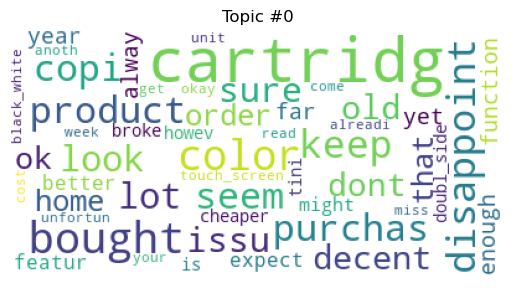

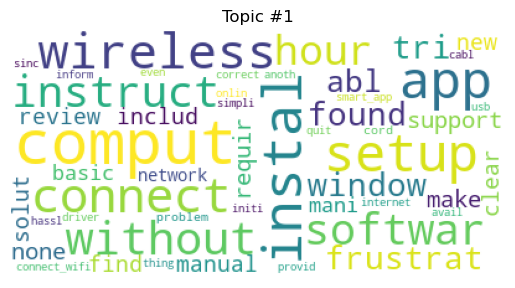

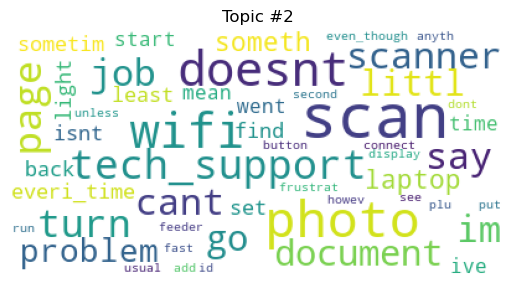

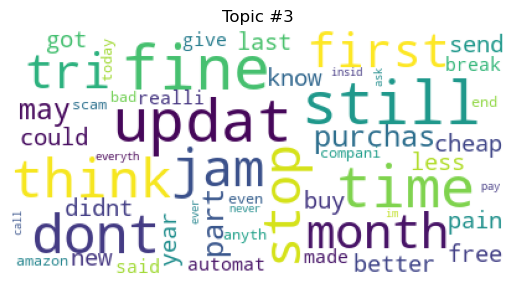

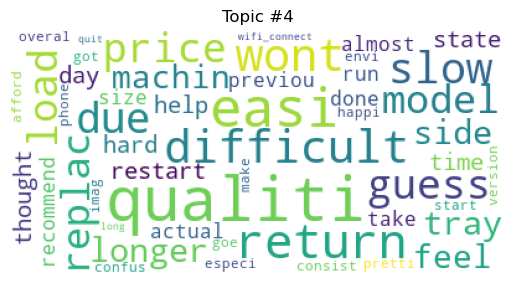

In [175]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

for t in range(neu_lda_model5.num_topics):
    plt.figure()
    plt.imshow(wc.fit_words(dict(neu_lda_model5.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()